In [1]:
!pip install wandb

In [2]:
import wandb
key = input('Enter your API:')
wandb.login(key=key)


Enter your API: 580e769ee2f34eafdded556ce52aaf31c265ad3b


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ma23m011 (ma23m011-iit-madras). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# 1. Data Loading and Transform
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to fixed size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])

train_data = ImageFolder(root='/kaggle/input/inutaral/inaturalist_12K/train', transform=transform)
test_data = ImageFolder(root='/kaggle/input/inutaral/inaturalist_12K/val', transform=transform)

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)




class CustomCNN(nn.Module):
    def __init__(self, input_channels=3, num_filters=None, kernel_size=3, 
                 activation='relu', dense_neurons=128, num_classes=10, 
                 dropout_rate=0.3, batch_norm=True, num_conv_layers=5, input_size=128):
        super(CustomCNN, self).__init__()
        self.activation = activation
        self.batch_norm = batch_norm
        self.dropout_rate = dropout_rate

        # Handle num_filters as int or list
        if num_filters is None:
            num_filters = [32, 64, 128, 256, 512]
        elif isinstance(num_filters, int):
            num_filters = [num_filters] * num_conv_layers
        elif isinstance(num_filters, list):
            assert len(num_filters) >= num_conv_layers

        # Handle kernel_size as int or list
        if isinstance(kernel_size, int):
            kernel_size = [kernel_size] * num_conv_layers
        elif isinstance(kernel_size, list):
            assert len(kernel_size) >= num_conv_layers
        else:
            raise TypeError("kernel_size must be a list or an integer.")

        # Handle dense_neurons as int or list
        if isinstance(dense_neurons, int):
            dense_neurons = [dense_neurons]
        elif isinstance(dense_neurons, list):
            assert all(isinstance(x, int) for x in dense_neurons)
        else:
            raise TypeError("dense_neurons must be a list or an integer.")

        # Convolutional layers
        layers = []
        in_channels = input_channels
        for i in range(num_conv_layers):
            out_channels = num_filters[i]
            k_size = kernel_size[i]
            layers.append(self.create_conv_block(in_channels, out_channels, k_size))
            in_channels = out_channels
        self.conv_layers = nn.Sequential(*layers)

        # Dynamically calculate flattened size
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, input_size, input_size)
            dummy_output = self.conv_layers(dummy_input)
            self.flattened_size = dummy_output.view(1, -1).size(1)

        # Dense layers
        self.flatten = nn.Flatten()
        fc_layers = []
        in_features = self.flattened_size
        for out_features in dense_neurons:
            fc_layers.append(nn.Linear(in_features, out_features))
            fc_layers.append(self.get_activation())
            fc_layers.append(nn.Dropout(self.dropout_rate))
            in_features = out_features
        fc_layers.append(nn.Linear(in_features, num_classes))  # Final output layer
        self.fc_layers = nn.Sequential(*fc_layers)

    def create_conv_block(self, in_channels, out_channels, kernel_size):
        padding = kernel_size // 2
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding)]
        if self.batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(self.get_activation())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        layers.append(nn.Dropout(self.dropout_rate))
        return nn.Sequential(*layers)

    def get_activation(self):
        activations = {
            'relu': nn.ReLU(),
            'gelu': nn.GELU(),
            'silu': nn.SiLU(),
            'mish': nn.Mish()
        }
        return activations.get(self.activation, nn.ReLU())

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

num_classes = len(train_data.classes)
model = CustomCNN(
    input_channels=3,
    input_size=128,
    num_classes=num_classes,
    num_conv_layers=5,
    num_filters=[32, 64, 128, 256, 512,1024],
    kernel_size=[3, 5, 3, 5, 1],  # ← Different kernel sizes for each conv layer
    dense_neurons=[512, 256, 64]
).to(device)

In [4]:
def train_model(config=None):
    with wandb.init(config=config):
        config = wandb.config

        # Create CNN model with hyperparameters
        model = CustomCNN(
            input_channels=3,
            num_filters=config.num_filters,
            activation=config.activation,
            dense_neurons=128,
            num_classes=10,
            dropout_rate=config.dropout_rate,
            batch_norm=config.batch_norm
        ).to(device)

        # Define loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        # Training loop
        for epoch in range(10):  # 10 epochs for demonstration
            model.train()
            running_loss = 0.0
            correct, total = 0, 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_acc = 100 * correct / total
            val_acc, val_loss = evaluate_model(model, val_loader, criterion)

            # Log metrics
            wandb.log({'train_loss': running_loss / len(train_loader), 'train_accuracy': train_acc,
                       'val_loss': val_loss, 'val_accuracy': val_acc})



In [5]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = running_loss / len(data_loader)
    return accuracy, avg_loss

In [14]:
import wandb

sweep_config = {
    'method': 'random',  # or 'grid' / 'bayes'
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'num_filters': {'values': [[16, 32, 64, 128, 256], [64, 64, 64, 64, 64], [256, 128, 64, 32, 16], [32, 32, 32,32,32], [16, 32, 64, 32, 16]] },  # Expanded filter options
        'activation': {'values': ['relu', 'gelu', 'silu', 'mish']},
        'batch_norm': {'values': [True, False]},
        'dropout_rate': {'values': [0.2, 0.3]},
        'data_augmentation': {'values': [True, False]},
        'filter_organization': {'values': ['same', 'double', 'half']},
        'kernel_size': {'values': [[3,3,3,3,3], [3,3,5,3,3], [3,5,3,5,3], [5,5,5,5,5], [5,7,7,3,5]]},  # New parameter added
        'dense_neurons': {'values':[[512], [256], [128], [64,128,256], [512, 256, 64]]}
    }
}


In [ ]:
# Initialize sweep and run
sweep_id = wandb.sweep(sweep_config, project='DL_A2')
wandb.agent(sweep_id, train_model, count=100)  # Run 20 experiments


Create sweep with ID: b1yopxtp
Sweep URL: https://wandb.ai/ma23m011-iit-madras/DL_A2/sweeps/b1yopxtp


wandb: Agent Starting Run: kdywzg6q with config:
wandb: 	activation: relu
wandb: 	batch_norm: True
wandb: 	data_augmentation: True
wandb: 	dense_neurons: [512]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: double
wandb: 	kernel_size: [5, 7, 7, 3, 5]
wandb: 	num_filters: [256, 128, 64, 32, 16]


train_accuracy,▁▄▅▆▆▆▇▇▇█
train_loss,█▆▄▄▃▃▂▂▁▁
val_accuracy,▁▂▃▆▆▆█▇▇█
val_loss,█▇▆▄▃▂▂▂▁▁
train_accuracy,33.96675
train_loss,1.86357
val_accuracy,35.2
val_loss,1.84242


wandb: Agent Starting Run: fk4zlths with config:
wandb: 	activation: gelu
wandb: 	batch_norm: True
wandb: 	data_augmentation: True
wandb: 	dense_neurons: [512, 256, 64]
wandb: 	dropout_rate: 0.2
wandb: 	filter_organization: double
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	num_filters: [16, 32, 64, 128, 256]


train_accuracy,▁▃▃▄▅▆▇▇▇█
train_loss,█▆▅▅▄▄▂▂▂▁
val_accuracy,▁▃▃▅▆▇▅▇██
val_loss,█▆▆▅▄▂▃▂▁▁
train_accuracy,31.85398
train_loss,1.8944
val_accuracy,32.6
val_loss,1.90126


wandb: Agent Starting Run: j28936kq with config:
wandb: 	activation: silu
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: [512]
wandb: 	dropout_rate: 0.2
wandb: 	filter_organization: half
wandb: 	kernel_size: [5, 7, 7, 3, 5]
wandb: 	num_filters: [64, 64, 64, 64, 64]


train_accuracy,▁▃▄▄▅▅▆▇▇█
train_loss,█▇▆▅▄▄▃▂▂▁
val_accuracy,▁▅▅▆▇▇▇██▆
val_loss,█▅▃▂▂▃▂▁▁▄
train_accuracy,46.99337
train_loss,1.50706
val_accuracy,33.05
val_loss,1.93441


wandb: Agent Starting Run: qw15j7a4 with config:
wandb: 	activation: mish
wandb: 	batch_norm: True
wandb: 	data_augmentation: True
wandb: 	dense_neurons: [512, 256, 64]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: half
wandb: 	kernel_size: [3, 3, 5, 3, 3]
wandb: 	num_filters: [16, 32, 64, 128, 256]


train_accuracy,▁▃▄▅▅▇▇▇▇█
train_loss,█▆▅▄▃▃▂▂▂▁
val_accuracy,▁▄▅▄▇██▇▇█
val_loss,█▅▄▅▃▂▁▂▂▁
train_accuracy,32.26653
train_loss,1.89841
val_accuracy,30.55
val_loss,1.92625


wandb: Agent Starting Run: p02ucyea with config:
wandb: 	activation: gelu
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: [256]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: same
wandb: 	kernel_size: [5, 7, 7, 3, 5]
wandb: 	num_filters: [32, 32, 32, 32, 32]


train_accuracy,▁▃▅▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▂▄▄▆▇▆▇██
val_loss,█▆▅▅▃▃▂▂▁▁
train_accuracy,37.40468
train_loss,1.76458
val_accuracy,35.15
val_loss,1.82223


wandb: Agent Starting Run: w2mzj30l with config:
wandb: 	activation: silu
wandb: 	batch_norm: True
wandb: 	data_augmentation: True
wandb: 	dense_neurons: [128]
wandb: 	dropout_rate: 0.2
wandb: 	filter_organization: same
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	num_filters: [16, 32, 64, 128, 256]


train_accuracy,▁▃▄▅▆▆▆▇██
train_loss,█▆▅▄▄▃▃▂▁▁
val_accuracy,▁▂▄▅▅▄▅█▇█
val_loss,█▇▅▄▄▄▃▁▃▁
train_accuracy,35.67946
train_loss,1.80794
val_accuracy,33.5
val_loss,1.8603


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kkcw098g with config:
wandb: 	activation: silu
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: [256]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: same
wandb: 	kernel_size: [5, 7, 7, 3, 5]
wandb: 	num_filters: [256, 128, 64, 32, 16]


train_accuracy,▁▄▅▅▆▇▇▇▇█
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▂▃▅▇▇▆▇█
val_loss,█▅▅▄▄▂▁▃▂▁
train_accuracy,33.05413
train_loss,1.87715
val_accuracy,32.75
val_loss,1.90855


wandb: Agent Starting Run: v8bccq45 with config:
wandb: 	activation: silu
wandb: 	batch_norm: True
wandb: 	data_augmentation: False
wandb: 	dense_neurons: [256]
wandb: 	dropout_rate: 0.2
wandb: 	filter_organization: same
wandb: 	kernel_size: [3, 3, 5, 3, 3]
wandb: 	num_filters: [16, 32, 64, 128, 256]


train_accuracy,▁▃▃▅▅▆▆▇▇█
train_loss,█▆▅▄▄▃▃▂▂▁
val_accuracy,▁▂▃▄▄▅▆▅▇█
val_loss,█▅▅▅▄▄▃▄▂▁
train_accuracy,37.30466
train_loss,1.78121
val_accuracy,35.55
val_loss,1.83547


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wtg2tmpk with config:
wandb: 	activation: gelu
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: [512]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: same
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	num_filters: [256, 128, 64, 32, 16]


train_accuracy,▁▄▅▆▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▄▅▆▆▇▆▇█
val_loss,█▆▆▄▃▃▃▃▂▁
train_accuracy,32.21653
train_loss,1.90398
val_accuracy,32.5
val_loss,1.88659


wandb: Agent Starting Run: gwoc53i0 with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: [512]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: half
wandb: 	kernel_size: [5, 7, 7, 3, 5]
wandb: 	num_filters: [64, 64, 64, 64, 64]


train_accuracy,▁▄▅▅▆▇▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▂▅▅▆▇▆▇██
val_loss,█▆▄▅▃▂▂▂▁▁
train_accuracy,32.029
train_loss,1.90548
val_accuracy,30.35
val_loss,1.92786


wandb: Agent Starting Run: tc7oroj1 with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: [512]
wandb: 	dropout_rate: 0.2
wandb: 	filter_organization: half
wandb: 	kernel_size: [3, 3, 5, 3, 3]
wandb: 	num_filters: [32, 32, 32, 32, 32]


train_accuracy,▁▄▄▅▅▆▇▇██
train_loss,█▆▆▅▄▃▃▂▂▁
val_accuracy,▁▄▄▆▆█▆███
val_loss,█▆▅▄▃▂▃▂▁▁
train_accuracy,32.42905
train_loss,1.90325
val_accuracy,30.45
val_loss,1.95213


wandb: Agent Starting Run: dn9mdtqv with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: [512, 256, 64]
wandb: 	dropout_rate: 0.2
wandb: 	filter_organization: double
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	num_filters: [64, 64, 64, 64, 64]


train_accuracy,▁▃▃▄▅▅▆▇▇█
train_loss,█▇▆▅▄▄▃▂▂▁
val_accuracy,▁▃▄▆▇█▆█▇█
val_loss,█▆▆▂▃▁▃▁▁▁
train_accuracy,48.006
train_loss,1.47914
val_accuracy,36.2
val_loss,1.83376


wandb: Agent Starting Run: espbine7 with config:
wandb: 	activation: mish
wandb: 	batch_norm: True
wandb: 	data_augmentation: True
wandb: 	dense_neurons: [512]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: half
wandb: 	kernel_size: [3, 5, 3, 5, 3]
wandb: 	num_filters: [16, 32, 64, 32, 16]


train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▂▄▃▄▆▄█▇
val_loss,█▆▆▅▆▅▂▄▁▁
train_accuracy,35.31691
train_loss,1.81932
val_accuracy,32.15
val_loss,1.88057


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7tc6urp8 with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: [512]
wandb: 	dropout_rate: 0.2
wandb: 	filter_organization: double
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	num_filters: [32, 32, 32, 32, 32]


train_accuracy,▁▃▄▅▅▆▆▇▇█
train_loss,█▆▅▅▄▃▃▂▂▁
val_accuracy,▁▃▄▅▅▆▇▆█▇
val_loss,█▆▅▄▃▃▂▃▁▁
train_accuracy,41.88024
train_loss,1.65565
val_accuracy,36.4
val_loss,1.80614


wandb: Agent Starting Run: 6rmmh8cm with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: [64, 128, 256]
wandb: 	dropout_rate: 0.2
wandb: 	filter_organization: double
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	num_filters: [64, 64, 64, 64, 64]


train_accuracy,▁▂▃▄▅▆▆▇▇█
train_loss,█▇▆▅▅▄▃▂▂▁
val_accuracy,▁▂▄▅▆█▇▇██
val_loss,█▇▅▄▂▁▂▂▂▁
train_accuracy,47.84348
train_loss,1.48587
val_accuracy,38.15
val_loss,1.79164


wandb: Agent Starting Run: z92uu248 with config:
wandb: 	activation: silu
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: [512, 256, 64]
wandb: 	dropout_rate: 0.2
wandb: 	filter_organization: half
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	num_filters: [256, 128, 64, 32, 16]


train_accuracy,▁▄▅▅▆▆▇▇██
train_loss,█▆▅▄▄▃▃▂▁▁
val_accuracy,▁▁▃▄▅▆▆▇▇█
val_loss,██▆▅▄▃▃▂▁▁
train_accuracy,36.74209
train_loss,1.7964
val_accuracy,34.75
val_loss,1.83783


wandb: Agent Starting Run: y2asm8w6 with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: [512, 256, 64]
wandb: 	dropout_rate: 0.2
wandb: 	filter_organization: double
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	num_filters: [256, 128, 64, 32, 16]


train_accuracy,▁▃▄▅▅▆▇▇██
train_loss,█▆▅▅▄▃▂▂▁▁
val_accuracy,▁▂▄▅▅▇▇██▇
val_loss,█▆▅▄▄▃▂▁▂▂
train_accuracy,37.91724
train_loss,1.76871
val_accuracy,33.8
val_loss,1.8737


wandb: Agent Starting Run: qgs8gzhr with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: [512]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: same
wandb: 	kernel_size: [3, 5, 3, 5, 3]
wandb: 	num_filters: [256, 128, 64, 32, 16]


train_accuracy,▁▄▅▅▆▆▇▇▇█
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▂▁▃▅▅▆▅▄█▆
val_loss,█▇▆▅▄▃▃▄▁▂
train_accuracy,26.79085
train_loss,2.02429
val_accuracy,25.4
val_loss,2.04123


wandb: Agent Starting Run: 9a8djfue with config:
wandb: 	activation: silu
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: [64, 128, 256]
wandb: 	dropout_rate: 0.2
wandb: 	filter_organization: double
wandb: 	kernel_size: [5, 5, 5, 5, 5]
wandb: 	num_filters: [16, 32, 64, 32, 16]


train_accuracy,▁▃▄▅▆▆▆▇██
train_loss,█▆▅▄▃▃▃▂▁▁
val_accuracy,▁▁▄▄▅▆▆▇██
val_loss,█▆▄▄▃▃▂▁▂▁
train_accuracy,37.32967
train_loss,1.79069
val_accuracy,34.2
val_loss,1.84722


wandb: Agent Starting Run: q43vs8v9 with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: [256]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: same
wandb: 	kernel_size: [5, 7, 7, 3, 5]
wandb: 	num_filters: [16, 32, 64, 32, 16]


train_accuracy,▁▃▄▅▆▇▇▇▇█
train_loss,█▆▅▄▄▃▂▂▂▁
val_accuracy,▁▃▄▅▆▆▇█▇█
val_loss,█▇▅▄▄▃▂▁▁▁
train_accuracy,35.00438
train_loss,1.8483
val_accuracy,33.8
val_loss,1.88287


wandb: Agent Starting Run: qbl893un with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: [256]
wandb: 	dropout_rate: 0.2
wandb: 	filter_organization: half
wandb: 	kernel_size: [3, 5, 3, 5, 3]
wandb: 	num_filters: [32, 32, 32, 32, 32]


train_accuracy,▁▃▅▅▆▆▇▇██
train_loss,█▆▅▄▄▃▂▂▂▁
val_accuracy,▁▅▅▅▆▆▇▇██
val_loss,█▆▅▄▄▃▂▂▁▁
train_accuracy,32.67908
train_loss,1.8993
val_accuracy,32.4
val_loss,1.92313


wandb: Agent Starting Run: vdh5n89w with config:
wandb: 	activation: silu
wandb: 	batch_norm: True
wandb: 	data_augmentation: False
wandb: 	dense_neurons: [512]
wandb: 	dropout_rate: 0.2
wandb: 	filter_organization: half
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	num_filters: [16, 32, 64, 128, 256]


train_accuracy,▁▃▄▅▆▆▇▇▇█
train_loss,█▆▅▄▄▃▂▂▂▁
val_accuracy,▁▃▄▅▅▇▅▇██
val_loss,█▆▄▄▃▂▄▂▁▁
train_accuracy,35.60445
train_loss,1.81955
val_accuracy,33.65
val_loss,1.86622


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ju49j1e7 with config:
wandb: 	activation: silu
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: [512]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: same
wandb: 	kernel_size: [3, 5, 3, 5, 3]
wandb: 	num_filters: [16, 32, 64, 32, 16]


train_accuracy,▁▃▄▅▆▆▇▇▇█
train_loss,█▆▅▄▄▃▃▂▂▁
val_accuracy,▁▂▄▅▅▆▇▅██
val_loss,█▆▅▄▃▃▂▃▁▁
train_accuracy,35.42943
train_loss,1.82987
val_accuracy,33.05
val_loss,1.87335


wandb: Agent Starting Run: gvh5g5xa with config:
wandb: 	activation: gelu
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: [64, 128, 256]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: half
wandb: 	kernel_size: [5, 5, 5, 5, 5]
wandb: 	num_filters: [16, 32, 64, 32, 16]


train_accuracy,▁▄▅▅▆▇▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▅▄▇▆█▇██
val_loss,█▆▅▅▃▃▂▂▂▁
train_accuracy,35.12939
train_loss,1.82398
val_accuracy,33.5
val_loss,1.85114


wandb: Agent Starting Run: mtjnwols with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: [512]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: half
wandb: 	kernel_size: [3, 3, 5, 3, 3]
wandb: 	num_filters: [64, 64, 64, 64, 64]


train_accuracy,▁▄▄▅▆▆▇▇██
train_loss,█▆▅▄▄▃▂▂▁▁
val_accuracy,▁▂▄▅▆▆▄▇█▇
val_loss,█▇▆▄▃▃▃▂▁▁
train_accuracy,31.00388
train_loss,1.93659
val_accuracy,28
val_loss,1.97305


wandb: Agent Starting Run: 8gozlonx with config:
wandb: 	activation: silu
wandb: 	batch_norm: True
wandb: 	data_augmentation: True
wandb: 	dense_neurons: [256]
wandb: 	dropout_rate: 0.2
wandb: 	filter_organization: same
wandb: 	kernel_size: [5, 7, 7, 3, 5]
wandb: 	num_filters: [256, 128, 64, 32, 16]


train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▄▃▂▂▁▁
val_accuracy,▁▂▅▄▆▆▆▇▇█
val_loss,█▆▅▆▃▃▃▂▂▁
train_accuracy,41.10514
train_loss,1.6822
val_accuracy,38.45
val_loss,1.73609


wandb: Agent Starting Run: vkoqxtbq with config:
wandb: 	activation: mish
wandb: 	batch_norm: True
wandb: 	data_augmentation: False
wandb: 	dense_neurons: [128]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: double
wandb: 	kernel_size: [3, 5, 3, 5, 3]
wandb: 	num_filters: [256, 128, 64, 32, 16]


train_accuracy,▁▃▄▅▆▆▇▇▇█
train_loss,█▆▅▄▄▃▂▂▁▁
val_accuracy,▁▃▃▄▅▅▅▆▇█
val_loss,█▇▆▅▄▅▅▃▂▁
train_accuracy,37.5922
train_loss,1.77466
val_accuracy,37.75
val_loss,1.77261


wandb: Agent Starting Run: dnpbf8z5 with config:
wandb: 	activation: mish
wandb: 	batch_norm: True
wandb: 	data_augmentation: False
wandb: 	dense_neurons: [512]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: same
wandb: 	kernel_size: [3, 3, 5, 3, 3]
wandb: 	num_filters: [16, 32, 64, 32, 16]


train_accuracy,▁▃▅▅▆▇▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▃▅▅▇▆▇██
val_loss,█▅▆▄▃▂▂▂▁▁
train_accuracy,35.9795
train_loss,1.81336
val_accuracy,33.15
val_loss,1.87577


wandb: Agent Starting Run: lyw4j5fb with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: [128]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: half
wandb: 	kernel_size: [5, 7, 7, 3, 5]
wandb: 	num_filters: [16, 32, 64, 128, 256]


train_accuracy,▁▃▅▅▆▆▇▇██
train_loss,█▇▅▄▄▃▃▂▁▁
val_accuracy,▁▃▅▅▆▇███▇
val_loss,█▆▄▄▃▂▂▁▁▂
train_accuracy,35.01688
train_loss,1.84727
val_accuracy,28.2
val_loss,1.96464


wandb: Agent Starting Run: f532cs55 with config:
wandb: 	activation: gelu
wandb: 	batch_norm: True
wandb: 	data_augmentation: False
wandb: 	dense_neurons: [128]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: double
wandb: 	kernel_size: [5, 7, 7, 3, 5]
wandb: 	num_filters: [16, 32, 64, 32, 16]


train_accuracy,▁▄▅▅▆▇▇▇▇█
train_loss,█▆▅▄▃▃▂▂▂▁
val_accuracy,▁▂▆▄▅█▇███
val_loss,██▃▆▅▁▂▁▁▁
train_accuracy,35.66696
train_loss,1.82812
val_accuracy,29.95
val_loss,1.94725


wandb: Agent Starting Run: 6c9p91is with config:
wandb: 	activation: mish
wandb: 	batch_norm: True
wandb: 	data_augmentation: False
wandb: 	dense_neurons: [64, 128, 256]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: double
wandb: 	kernel_size: [5, 5, 5, 5, 5]
wandb: 	num_filters: [32, 32, 32, 32, 32]


train_accuracy,▁▃▅▆▆▇▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▆▇▆▇▇█▇▇
val_loss,█▅▄▃▃▂▂▁▂▁
train_accuracy,36.0295
train_loss,1.79743
val_accuracy,33.5
val_loss,1.84724


wandb: Agent Starting Run: gn53vpva with config:
wandb: 	activation: relu
wandb: 	batch_norm: True
wandb: 	data_augmentation: False
wandb: 	dense_neurons: [512]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: double
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	num_filters: [64, 64, 64, 64, 64]


train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▆▅▄▃▃▂▂▂▁
val_accuracy,▁▃▄▆▂▆▄▅█▇
val_loss,█▇▅▃▆▃▅▂▁▁
train_accuracy,33.16665
train_loss,1.86302
val_accuracy,32.25
val_loss,1.88451


wandb: Agent Starting Run: kwjcixzx with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: [128]
wandb: 	dropout_rate: 0.2
wandb: 	filter_organization: same
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	num_filters: [64, 64, 64, 64, 64]


train_accuracy,▁▃▄▄▅▆▆▇▇█
train_loss,█▇▆▅▄▄▃▂▂▁
val_accuracy,▁▄▄▆▆▄████
val_loss,█▅▅▃▃▅▁▁▂▁
train_accuracy,48.21853
train_loss,1.4892
val_accuracy,37.05
val_loss,1.81157


wandb: Agent Starting Run: 6piy4aod with config:
wandb: 	activation: relu
wandb: 	batch_norm: True
wandb: 	data_augmentation: True
wandb: 	dense_neurons: [64, 128, 256]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: same
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	num_filters: [16, 32, 64, 128, 256]


train_accuracy,█▄▄▃▃▁▂▄▁▄
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▁▁▁▁
train_accuracy,10.20128
train_loss,2.30278
val_accuracy,9.2
val_loss,2.30306


wandb: Agent Starting Run: s17ql9y4 with config:
wandb: 	activation: silu
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: [512]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: same
wandb: 	kernel_size: [3, 3, 5, 3, 3]
wandb: 	num_filters: [32, 32, 32, 32, 32]


train_accuracy,▁▃▅▅▆▆▇███
train_loss,█▆▅▄▃▃▂▂▂▁
val_accuracy,▁▃▄▄▅▆▆▇▇█
val_loss,█▇▅▅▄▃▂▂▂▁
train_accuracy,36.36705
train_loss,1.79458
val_accuracy,36.25
val_loss,1.80635


wandb: Agent Starting Run: 7f8adbvu with config:
wandb: 	activation: silu
wandb: 	batch_norm: True
wandb: 	data_augmentation: False
wandb: 	dense_neurons: [64, 128, 256]
wandb: 	dropout_rate: 0.2
wandb: 	filter_organization: half
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	num_filters: [16, 32, 64, 128, 256]


train_accuracy,▁▃▄▄▅▆▆▇▇█
train_loss,█▆▅▅▄▃▃▂▂▁
val_accuracy,▁▃▄▅▆▆▇▇▇█
val_loss,█▆▅▄▄▃▃▂▂▁
train_accuracy,38.72984
train_loss,1.73881
val_accuracy,35.95
val_loss,1.80361


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4q7keryw with config:
wandb: 	activation: gelu
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: [128]
wandb: 	dropout_rate: 0.2
wandb: 	filter_organization: double
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	num_filters: [256, 128, 64, 32, 16]


train_accuracy,▁▃▅▅▆▆▇▇██
train_loss,█▆▅▄▄▃▂▂▁▁
val_accuracy,▁▃▄▅▆▆▇█▇█
val_loss,█▆▄▄▃▃▁▁▁▁
train_accuracy,35.42943
train_loss,1.8162
val_accuracy,34.9
val_loss,1.85149


wandb: Agent Starting Run: lwr9naii with config:
wandb: 	activation: gelu
wandb: 	batch_norm: True
wandb: 	data_augmentation: False
wandb: 	dense_neurons: [512, 256, 64]
wandb: 	dropout_rate: 0.2
wandb: 	filter_organization: half
wandb: 	kernel_size: [3, 5, 3, 5, 3]
wandb: 	num_filters: [16, 32, 64, 32, 16]


train_accuracy,▁▄▅▅▆▇▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▅▆▆▅▆▇██
val_loss,█▆▃▂▂▂▃▂▁▁
train_accuracy,37.86723
train_loss,1.75274
val_accuracy,34.25
val_loss,1.86205


wandb: Agent Starting Run: rf01jhsc with config:
wandb: 	activation: silu
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: [256]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: half
wandb: 	kernel_size: [5, 7, 7, 3, 5]
wandb: 	num_filters: [64, 64, 64, 64, 64]


train_accuracy,▁▃▄▅▅▆▇▇██
train_loss,█▆▅▅▄▃▃▂▂▁
val_accuracy,▁▃▄▃▅▆▇█▇█
val_loss,█▆▅▆▄▃▃▂▂▁
train_accuracy,41.49269
train_loss,1.65511
val_accuracy,38
val_loss,1.74485


wandb: Agent Starting Run: fziljpmv with config:
wandb: 	activation: silu
wandb: 	batch_norm: True
wandb: 	data_augmentation: True
wandb: 	dense_neurons: [128]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: same
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	num_filters: [32, 32, 32, 32, 32]


train_accuracy,▁▃▅▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▃▅▆▄██▇█
val_loss,█▆▅▄▃▄▁▁▁▁
train_accuracy,37.25466
train_loss,1.78135
val_accuracy,33.6
val_loss,1.8575


wandb: Agent Starting Run: 9rfmyrjt with config:
wandb: 	activation: gelu
wandb: 	batch_norm: True
wandb: 	data_augmentation: True
wandb: 	dense_neurons: [128]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: same
wandb: 	kernel_size: [5, 5, 5, 5, 5]
wandb: 	num_filters: [16, 32, 64, 32, 16]


train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▄▃▂▂▂▁▁
val_accuracy,▁▃▆▃▃▆▅▆▆█
val_loss,█▇▅▆▇▃▄▃▃▁
train_accuracy,34.12927
train_loss,1.84808
val_accuracy,30.5
val_loss,1.91481


wandb: Agent Starting Run: x9j11hhq with config:
wandb: 	activation: silu
wandb: 	batch_norm: True
wandb: 	data_augmentation: True
wandb: 	dense_neurons: [512, 256, 64]
wandb: 	dropout_rate: 0.2
wandb: 	filter_organization: half
wandb: 	kernel_size: [3, 5, 3, 5, 3]
wandb: 	num_filters: [32, 32, 32, 32, 32]


train_accuracy,▁▃▄▅▆▆▇▇▇█
train_loss,█▆▅▄▄▃▂▂▂▁
val_accuracy,▁▄▄▆▅▆▆▇▇█
val_loss,█▆▅▄▃▃▄▃▃▁
train_accuracy,40.29254
train_loss,1.68614
val_accuracy,37.9
val_loss,1.76076


wandb: Agent Starting Run: rfff7h6q with config:
wandb: 	activation: gelu
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: [256]
wandb: 	dropout_rate: 0.2
wandb: 	filter_organization: same
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	num_filters: [256, 128, 64, 32, 16]


train_accuracy,▁▃▅▅▆▆▇▇██
train_loss,█▆▅▄▄▃▂▂▁▁
val_accuracy,▁▃▄▅▆▇▇▇██
val_loss,█▇▅▅▄▃▂▃▂▁
train_accuracy,36.74209
train_loss,1.8068
val_accuracy,34.95
val_loss,1.8376


wandb: Agent Starting Run: zrw7tjq7 with config:
wandb: 	activation: silu
wandb: 	batch_norm: True
wandb: 	data_augmentation: True
wandb: 	dense_neurons: [256]
wandb: 	dropout_rate: 0.2
wandb: 	filter_organization: same
wandb: 	kernel_size: [3, 5, 3, 5, 3]
wandb: 	num_filters: [32, 32, 32, 32, 32]


train_accuracy,▁▃▄▅▆▆▆▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▅▅▆▆▇█▆▇
val_loss,█▆▄▄▃▃▃▁▃▂
train_accuracy,41.38017
train_loss,1.67373
val_accuracy,34.85
val_loss,1.81491


wandb: Agent Starting Run: e1gvctwk with config:
wandb: 	activation: gelu
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: [512]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: double
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	num_filters: [256, 128, 64, 32, 16]


train_accuracy,▁▄▅▅▆▇▇▇██
train_loss,█▆▅▄▃▃▂▂▂▁
val_accuracy,▁▃▄▄▄▆▆▇▇█
val_loss,█▇▅▄▅▃▃▃▂▁
train_accuracy,32.45406
train_loss,1.89749
val_accuracy,32.3
val_loss,1.8909


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 71lzxqsd with config:
wandb: 	activation: silu
wandb: 	batch_norm: True
wandb: 	data_augmentation: False
wandb: 	dense_neurons: [512, 256, 64]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: half
wandb: 	kernel_size: [5, 7, 7, 3, 5]
wandb: 	num_filters: [32, 32, 32, 32, 32]


train_accuracy,▁▄▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▆▆▆▆▆█▇█
val_loss,█▆▄▄▃▄▂▁▂▁
train_accuracy,37.6172
train_loss,1.77427
val_accuracy,33.95
val_loss,1.86015


wandb: Agent Starting Run: 7un854xs with config:
wandb: 	activation: gelu
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: [512, 256, 64]
wandb: 	dropout_rate: 0.2
wandb: 	filter_organization: half
wandb: 	kernel_size: [5, 5, 5, 5, 5]
wandb: 	num_filters: [256, 128, 64, 32, 16]


train_accuracy,▁▄▅▅▆▆▇▇██
train_loss,█▆▅▄▄▃▃▂▂▁
val_accuracy,▁▂▄▅▄▆▆▇▇█
val_loss,█▇▆▅▄▄▄▂▂▁
train_accuracy,36.40455
train_loss,1.79315
val_accuracy,35.15
val_loss,1.81871


wandb: Agent Starting Run: lxp03i06 with config:
wandb: 	activation: relu
wandb: 	batch_norm: True
wandb: 	data_augmentation: False
wandb: 	dense_neurons: [128]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: same
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	num_filters: [16, 32, 64, 32, 16]


train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▄▄▆█▇▇▆▇
val_loss,█▆▆▅▄▁▃▁▆▂
train_accuracy,32.31654
train_loss,1.90278
val_accuracy,27.5
val_loss,2.00183


wandb: Agent Starting Run: oa0ju2ra with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	data_augmentation: False
wandb: 	dense_neurons: [128]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: double
wandb: 	kernel_size: [5, 5, 5, 5, 5]
wandb: 	num_filters: [64, 64, 64, 64, 64]


train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▅▄▃▃▂▂▁
val_accuracy,▁▃▃▇▆▆▇▇██
val_loss,█▆▆▃▂▂▂▁▁▂
train_accuracy,40.09251
train_loss,1.68123
val_accuracy,35.75
val_loss,1.83036


wandb: Agent Starting Run: 7v7hhom2 with config:
wandb: 	activation: silu
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dense_neurons: [128]
wandb: 	dropout_rate: 0.3
wandb: 	filter_organization: half
wandb: 	kernel_size: [3, 3, 5, 3, 3]
wandb: 	num_filters: [64, 64, 64, 64, 64]


In [6]:

# ✅ Define best config from sweep BEFORE wandb.init
best_config = {
    'num_filters':  [256, 128, 64, 32, 16],
    'activation': 'silu',
    'dropout_rate': 0.3,
    'batch_norm': True
}

# ✅ Initialize wandb project
wandb.init(
    project="DL_A2",  # 👈 change to your desired project name
    config=best_config,
    name="best-model-run",  # 👈 optional run name
)


# Initialize the model with best config
best_model = CustomCNN(
    input_channels=3,
    num_filters=best_config['num_filters'],
    activation=best_config['activation'],
    dense_neurons=128,
    num_classes=len(train_data.classes),
    dropout_rate=best_config['dropout_rate'],
    batch_norm=best_config['batch_norm'],
    num_conv_layers=len(best_config['num_filters'])  # ✅ added this
).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(best_model.parameters(), lr=0.001)

# Train for N epochs
for epoch in range(15):  # or more
    best_model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = best_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    val_acc, val_loss = evaluate_model(best_model, val_loader, criterion)

    # ✅ Log metrics to wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_accuracy": train_acc,
        "train_loss": running_loss / len(train_loader),
        "val_accuracy": val_acc,
        "val_loss": val_loss
     })

    print(f"[Epoch {epoch+1}] Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

[Epoch 1] Train Acc: 21.20%, Val Acc: 25.75%
[Epoch 2] Train Acc: 25.99%, Val Acc: 30.15%
[Epoch 3] Train Acc: 28.63%, Val Acc: 31.55%
[Epoch 4] Train Acc: 29.93%, Val Acc: 32.35%
[Epoch 5] Train Acc: 32.24%, Val Acc: 33.35%
[Epoch 6] Train Acc: 33.20%, Val Acc: 35.45%
[Epoch 7] Train Acc: 34.54%, Val Acc: 35.20%
[Epoch 8] Train Acc: 35.93%, Val Acc: 35.50%
[Epoch 9] Train Acc: 35.65%, Val Acc: 35.90%
[Epoch 10] Train Acc: 37.08%, Val Acc: 37.00%
[Epoch 11] Train Acc: 38.40%, Val Acc: 36.55%
[Epoch 12] Train Acc: 38.63%, Val Acc: 32.05%
[Epoch 13] Train Acc: 39.49%, Val Acc: 37.65%
[Epoch 14] Train Acc: 40.61%, Val Acc: 39.20%
[Epoch 15] Train Acc: 40.38%, Val Acc: 39.75%


In [7]:
# 4. Set model to evaluation mode
best_model.eval()

# 5. ✅ PASTE THIS HERE: Accuracy on test set (manual version)
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")

# ✅ Log to wandb
wandb.log({"test_accuracy": test_accuracy * 100})

✅ Test Accuracy: 40.80%


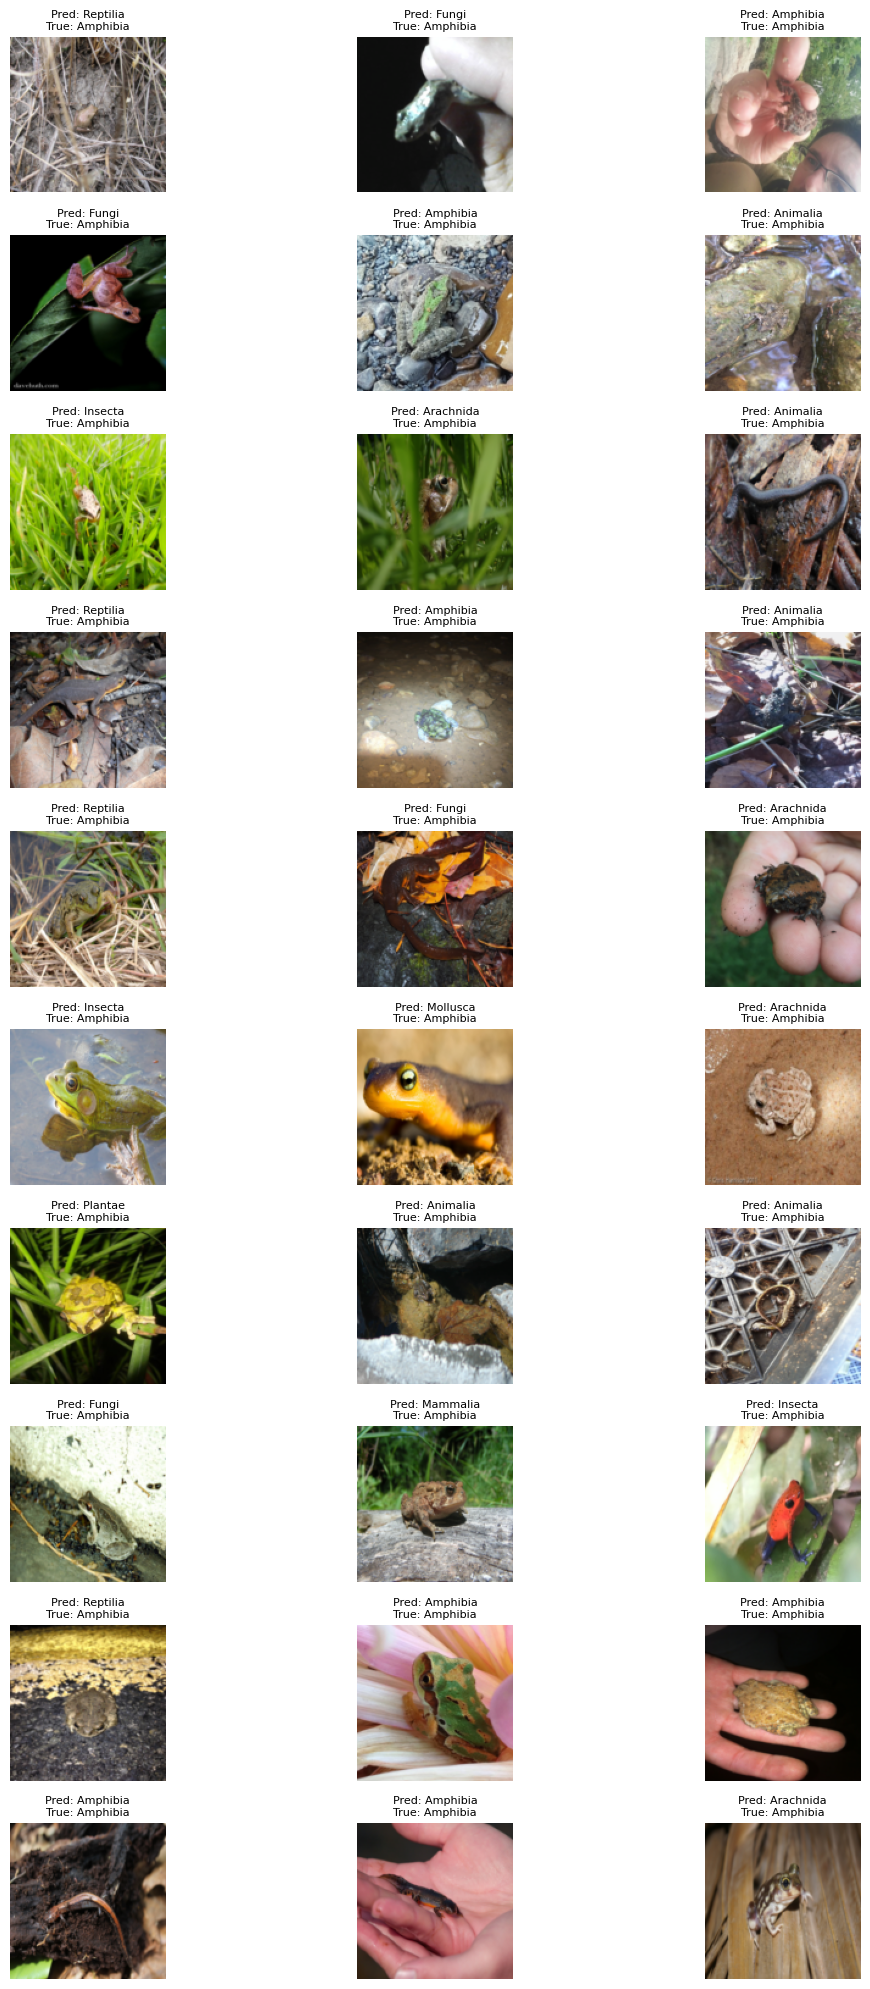

<Figure size 640x480 with 0 Axes>

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    return img

def show_predictions(model, dataloader, class_names, num_images=30):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(12, 20))
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size(0)):
                if images_shown >= num_images:
                    break
                img = imshow(inputs[j])
                plt.subplot(10, 3, images_shown + 1)
                plt.imshow(img)
                plt.title(f"Pred: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}", fontsize=8)
                plt.axis('off')
                images_shown += 1
            if images_shown >= num_images:
                break
    plt.tight_layout()
    plt.show()

    
    # ✅ Log predictions to wandb
    plt.savefig("predictions.png")
    wandb.log({"sample_predictions": wandb.Image("predictions.png")})




# ✅ Display 10x3 predictions from test set
show_predictions(best_model, test_loader, train_data.classes, num_images=30)


In [12]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🔧 1. Define transforms to match ImageNet expectations
transform = transforms.Compose([
    transforms.Resize((224, 224)),         # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean/std
                         std=[0.229, 0.224, 0.225])
])

# 🗂 2. Load your dataset (naturalist)
train_data = ImageFolder('/kaggle/input/inutaral/inaturalist_12K/train', transform=transform)
val_data = ImageFolder('/kaggle/input/inutaral/inaturalist_12K/val', transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

# ✅ 3. Load pretrained ResNet50
model = models.resnet50(pretrained=True)

# 🔄 4. Replace the final classification layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # 10 classes for naturalist dataset

model = model.to(device)

# Print to confirm
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 234MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 